In [ ]:
import kagglehub
rashikrahmanpritom_plant_disease_recognition_dataset_path = kagglehub.dataset_download('rashikrahmanpritom/plant-disease-recognition-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import *

In [ ]:
path = rashikrahmanpritom_plant_disease_recognition_dataset_path

for item in os.listdir(path):
    print(item)
    print("Is folder:", os.path.isdir(os.path.join(path, item)))

Validation
Is folder: True
Test
Is folder: True
Train
Is folder: True


In [ ]:
def loadingData(DSpath, imagesize =(224, 224)):
    imgs, lbls = [], []
    for cls in sorted(os.listdir(DSpath)):
        clspath = os.path.join(DSpath, cls)
        if not os.path.isdir(clspath): continue
        for imgnm in os.listdir(clspath):
            img = cv2.imread(os.path.join(clspath,imgnm))
            if img is not None:
                imgs.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imagesize))
                lbls.append(cls)

    return np.array(imgs), np.array(lbls)


# Loading Data to a train path, validation path, test path

In [ ]:
base = rashikrahmanpritom_plant_disease_recognition_dataset_path
trainpth, valpth, testpth = [os.path.join(base, x) for x in ['Train/Train', 'Validation/Validation', 'Test/Test']]

# EDA

In [ ]:
# How many files found in each path
def count_images_in_folder(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        total += len(os.listdir(class_folder))
    return total

train_count = count_images_in_folder(trainpth)
val_count = count_images_in_folder(valpth)
test_count = count_images_in_folder(testpth)

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Train images: 1322
Validation images: 60
Test images: 150


In [ ]:
# How many classes in the train path
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    files = os.listdir(class_folder)
    print(f"{class_name}: {len(files)} images")

Healthy: 458 images
Rust: 434 images
Powdery: 430 images


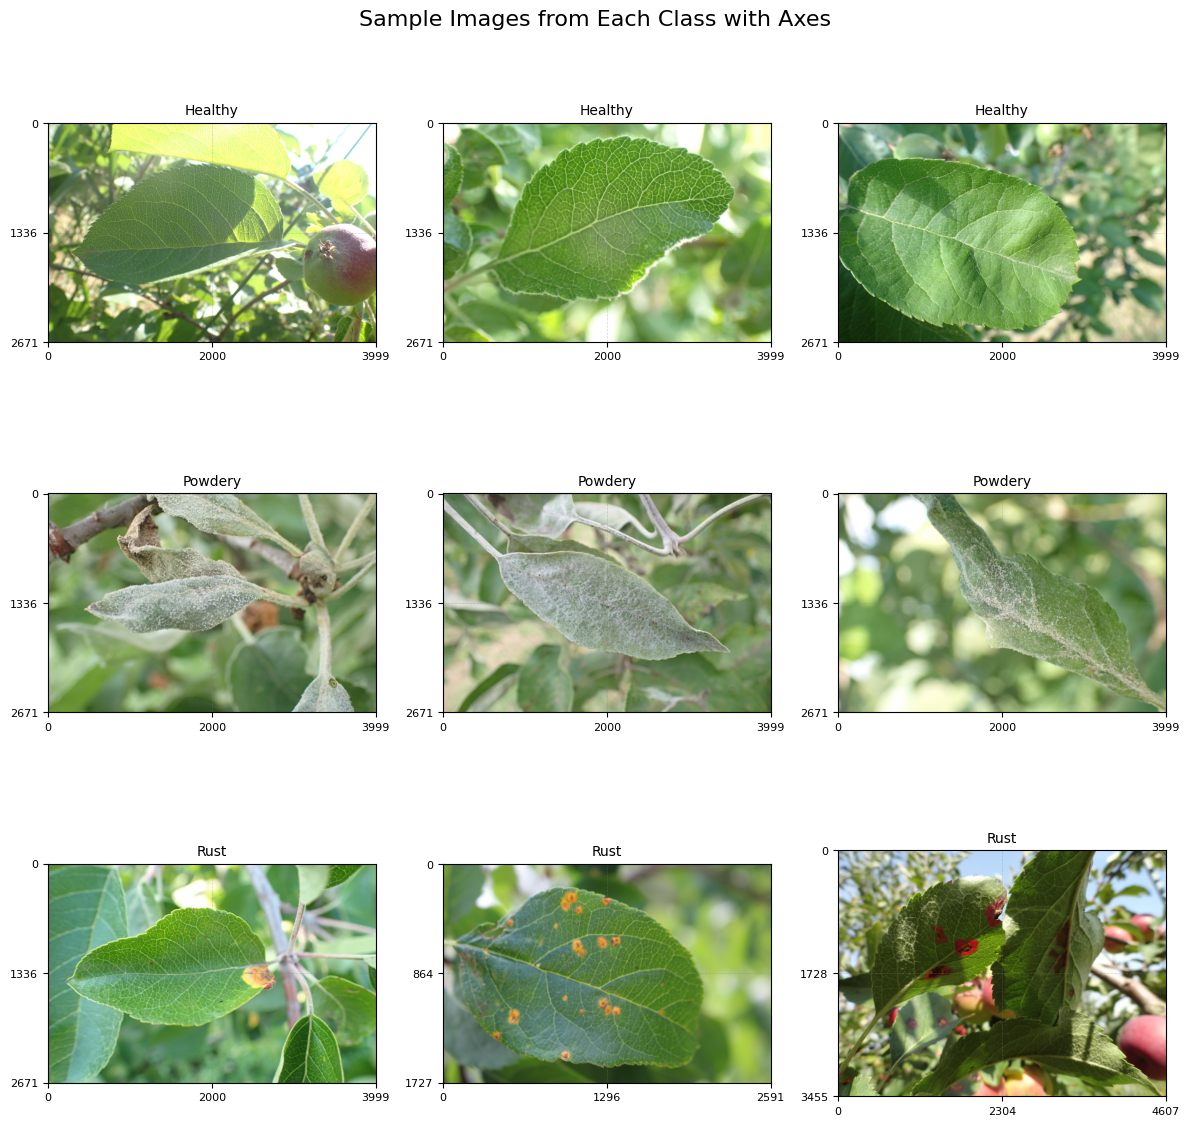

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def show_sample_images_with_axes(data_path, classes, image_per_class=2):
    fig, axs = plt.subplots(len(classes), image_per_class, figsize=(image_per_class * 4, len(classes) * 4))

    if len(classes) == 1:
        axs = [axs]  # handle when there is only one class
    elif image_per_class == 1:
        axs = [[ax] for ax in axs]  # handle 1 column

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        images = os.listdir(class_folder)[:image_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            ax = axs[i][j]
            ax.imshow(img)
            ax.set_title(f"{class_name}", fontsize=10)
            ax.set_xticks([0, img.shape[1]//2, img.shape[1]-1])
            ax.set_yticks([0, img.shape[0]//2, img.shape[0]-1])
            ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=8)

    plt.suptitle("Sample Images from Each Class with Axes", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images_with_axes(trainpth, ['Healthy', 'Powdery', 'Rust'], image_per_class=3)

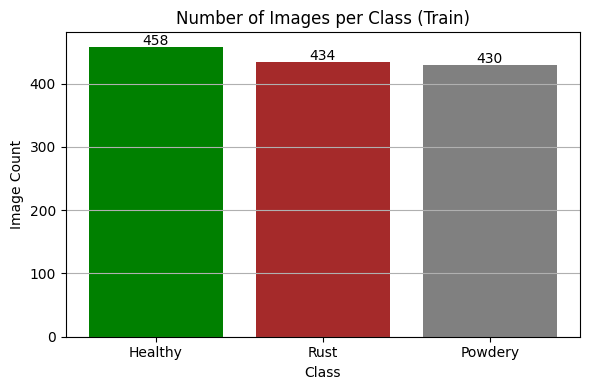

In [ ]:
# Visualizing classes imbalances
import os
import matplotlib.pyplot as plt
import numpy as np

class_counts = {}
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['green', 'brown', 'grey'])
plt.title('Number of Images per Class (Train)')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.grid(axis='y')

for i in range(len(classes)):
    plt.text(i, counts[i] + 3, str(counts[i]), ha='center')

plt.tight_layout()
plt.show()

# Splitting data found in each path to features(x) and target(y)

In [ ]:
x_train_origin, y_train = loadingData(trainpth)
x_val_origin, y_val = loadingData(valpth)
x_test_origin, y_test = loadingData(testpth)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
num_classes = len(np.unique(y_train_encoded))
print(f"You have {num_classes} unique classes in your data.")

You have 3 unique classes in your data.


In [ ]:
print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {np.str_('Healthy'): np.int64(0), np.str_('Powdery'): np.int64(1), np.str_('Rust'): np.int64(2)}


# Preprocessing

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

def DataGenerator(model='CNN'):
    if model == 'CNN':
        preprocessing = None
        rescale = 1.0 / 255.0
    elif model == 'VGG':
        preprocessing = vgg_preprocess
        rescale = None
    elif model == 'ResNet50':
        preprocessing = resnet_preprocess
        rescale = None
    else:
        raise ValueError("Invalid model name")

    datagen = ImageDataGenerator(
        rotation_range=20,
        validation_split=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=rescale,
        preprocessing_function=preprocessing
    )

    return datagen

# Custom CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Define your model
model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # Replace `num_classes` with your actual number
])

In [ ]:
model_CNN.compile(
    optimizer=optimizerSGD,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.optimizers import SGD
optimizerSGD = SGD(learning_rate=0.001, momentum=0.9,nesterov=True)
model_custom.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizerSGD,
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#reduce_lr = ReduceLROnPlateau(
#    monitor='val_loss',
#    factor=0.5,
#    patience=3,
#    verbose=1,
#    min_lr=1e-4
#)

# ===============================================================
# 🔍 LESSON LEARNED: Accuracy was stuck around 33% — THE WHY?
# ---------------------------------------------------------------
# After a lot of debugging, it turned out the issue was NOT data quality,
# NOT model architecture, NOT augmentation... It was the LEARNING RATE! 😱
#
# ✅ If the learning rate is TOO HIGH:
#    ➤ The model keeps "jumping around" and fails to learn.
#
# ✅ If it's TOO LOW:
#    ➤ The model barely updates, and training stays flat.
#
# ✅ In my case: Lowering the learning rate (e.g. from 0.001 → 0.0001)
#    made the model start learning properly and improve accuracy! 🎯
# ===============================================================

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_cnn_train = DataGenerator(model='CNN')
train_generator = datagen_cnn_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_cnn_val = DataGenerator(model='CNN')
val_generator = datagen_cnn_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [ ]:
history = model_custom.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5646 - loss: 1.6881 - val_accuracy: 0.3333 - val_loss: 2.1290
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 726ms/step - accuracy: 0.7770 - loss: 0.5786 - val_accuracy: 0.3333 - val_loss: 3.8804
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 724ms/step - accuracy: 0.8223 - loss: 0.4606 - val_accuracy: 0.3333 - val_loss: 5.3610
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 715ms/step - accuracy: 0.8761 - loss: 0.3426 - val_accuracy: 0.3333 - val_loss: 6.1032
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - accuracy: 0.9207 - loss: 0.2616 - val_accuracy: 0.3333 - val_loss: 7.7636
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.9077 - loss: 0.2514 - val_accuracy: 0.3333 - val_loss: 7.9819


In [ ]:
model_custom.save('best_cnn_model.h5')

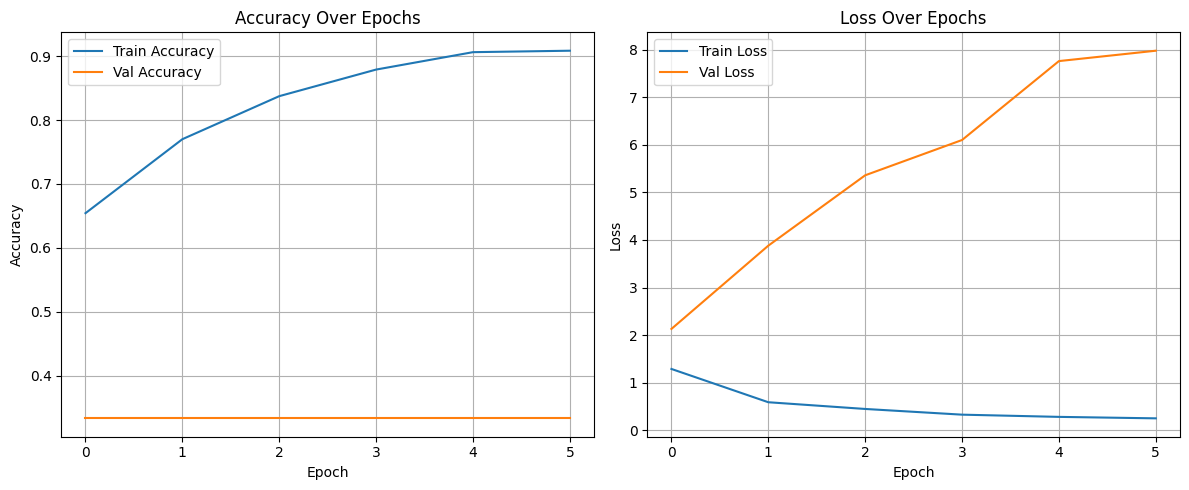

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
datagen_CNN_test = DataGenerator(model='CNN')
test_generator_CNN = datagen_CNN_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs_CNN = model_custom.predict(test_generator_CNN)
y_pred_CNN = np.argmax(y_pred_probs_CNN, axis=1)
y_true = y_test_encoded

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


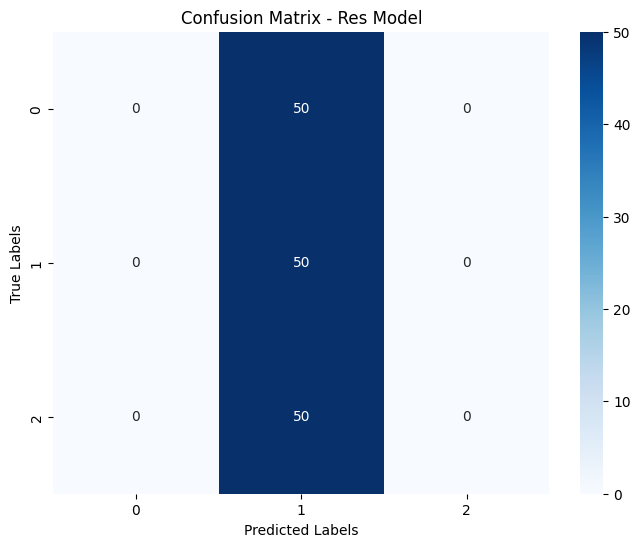

              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00        50
     class_1       0.33      1.00      0.50        50
     class_2       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_CNN)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Res Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']
report = classification_report(y_true, y_pred_CNN, target_names=class_names)
print(report)

# The CNN is a real loser here

# VGG Model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

for layer in base_model.layers[10:]:
    layer.trainable = True
model_VGG = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

In [ ]:
model_VGG.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacky =[
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

In [ ]:
datagen_vgg_train = DataGenerator(model='VGG')
train_generator_vgg = datagen_vgg_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_vgg_val = DataGenerator(model='VGG')
val_generator_vgg = datagen_vgg_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [ ]:
#callbacky =[
#    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#    ModelCheckpoint('best_model.h5', save_best_only=True)
#]

In [ ]:
history = model_VGG.fit(
  train_generator_vgg,
  validation_data=val_generator_vgg,
  epochs=20,
  #callbacks=callbacky,
  batch_size=64
  )

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 930ms/step - accuracy: 0.7991 - loss: 0.4874 - val_accuracy: 0.3833 - val_loss: 1.4875
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 929ms/step - accuracy: 0.8410 - loss: 0.4237 - val_accuracy: 0.6500 - val_loss: 0.7078
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 940ms/step - accuracy: 0.8747 - loss: 0.3561 - val_accuracy: 0.6667 - val_loss: 0.5804
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 873ms/step - accuracy: 0.9060 - loss: 0.2897 - val_accuracy: 0.9000 - val_loss: 54.3084
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 914ms/step - accuracy: 0.9595 - loss: 0.1546 - val_accuracy: 0.9500 - val_loss: 0.1460
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 889ms/step - accuracy: 0.9654 - loss: 0.1073 - val_accuracy: 0.7833 - val_loss: 0.5366
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 934ms/step - accuracy: 0.9645 - loss: 0.0970 - val_accuracy: 0.9667 - val_loss: 0.0792
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 917ms/step - accuracy: 0.9784 - loss: 0.0657 - val_acc

In [ ]:
import numpy as np

# Save history for later use
np.save('vgg_history.npy', history.history)

In [ ]:
model_VGG.save('vgg_model_full.h5')

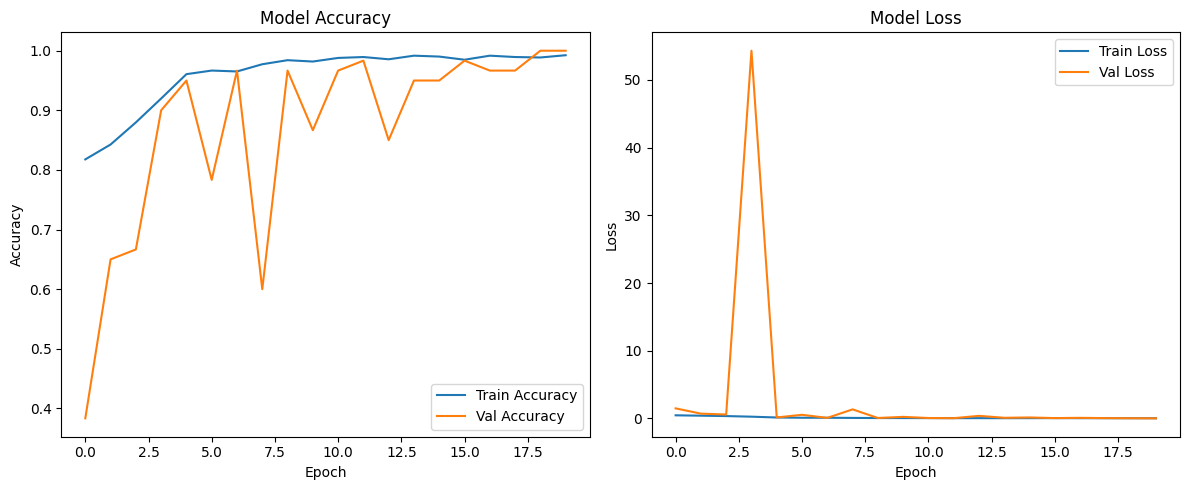

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
datagen_vgg_test = DataGenerator(model='VGG')
test_generator_vgg = datagen_vgg_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs = model_VGG.predict(test_generator_vgg)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_encoded

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step


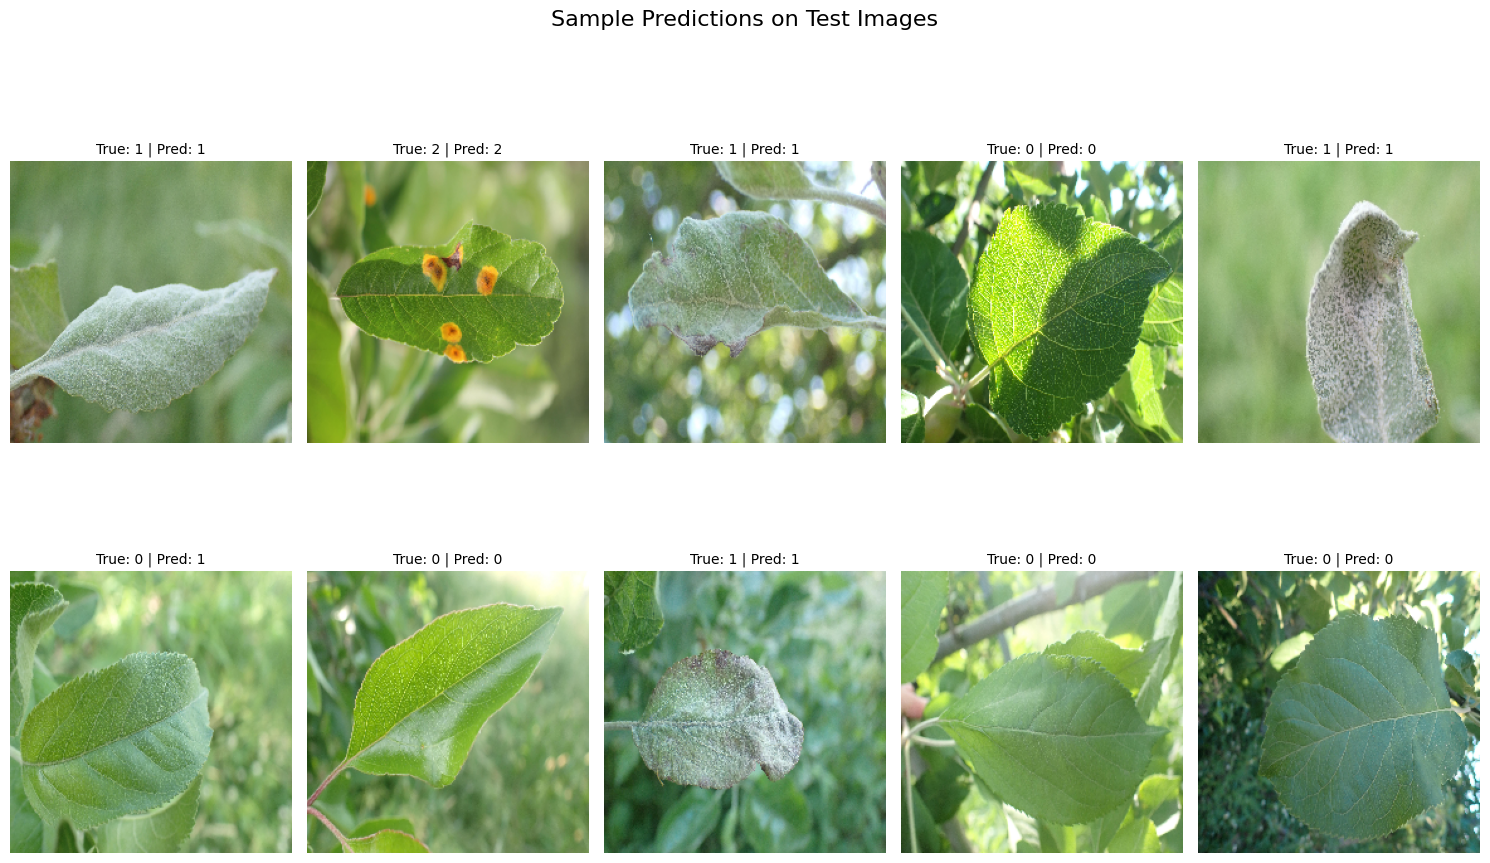

In [ ]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
y_true = y_test_encoded

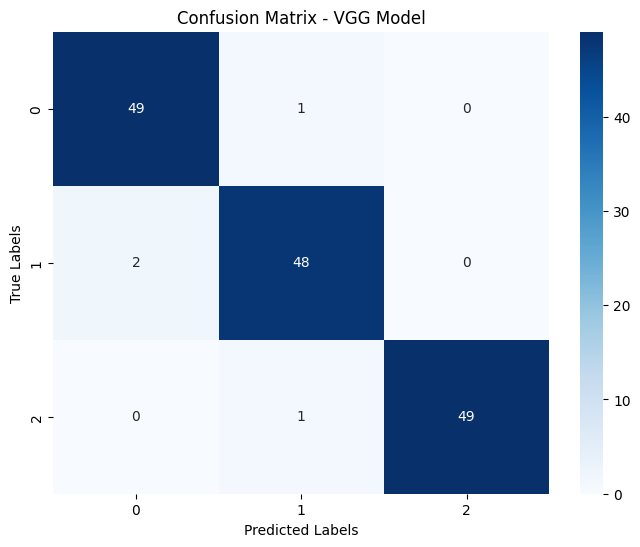

              precision    recall  f1-score   support

     class_0       0.96      0.98      0.97        50
     class_1       0.96      0.96      0.96        50
     class_2       1.00      0.98      0.99        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - VGG Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']  # ← غيريها حسب أسماء الكلاسات عندك
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ResNet50

In [ ]:
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_res.layers[:100]:
    layer.trainable = False
for layer in base_model_res.layers[100:]:
    layer.trainable = True


model_RES = Sequential([
    base_model_res,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
model_RES.compile(loss='sparse_categorical_crossentropy', optimizer=optimizerSGD, metrics=['accuracy'])

In [ ]:
callbacky_res = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

In [ ]:
datagen_res_train = DataGenerator(model='ResNet50')
train_generator_res = datagen_res_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_res_val = DataGenerator(model='ResNet50')
val_generator_res = datagen_res_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [ ]:
history_res = model_RES.fit(
    train_generator_res,
    validation_data=val_generator_res,
    epochs=20,
    callbacks=callbacky_res,
    batch_size=64
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5587 - loss: 1.1754

21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5668 - loss: 1.1527 - val_accuracy: 0.9500 - val_loss: 0.2170
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.9557 - loss: 0.1331

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 850ms/step - accuracy: 0.9561 - loss: 0.1323 - val_accuracy: 0.9833 - val_loss: 0.0628
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 771ms/step - accuracy: 0.9772 - loss: 0.0796 - val_accuracy: 0.9833 - val_loss: 0.0805
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 825ms/step - accuracy: 0.9874 - loss: 0.0375 - val_accuracy: 0.9833 - val_loss: 0.0654
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9882 - loss: 0.0452

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 970ms/step - accuracy: 0.9881 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9863 - loss: 0.0422

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 866ms/step - accuracy: 0.9863 - loss: 0.0422 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 777ms/step - accuracy: 0.9892 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 830ms/step - accuracy: 0.9923 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 799ms/step - accuracy: 0.9922 - loss: 0.0253 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9994 - loss: 0.0087

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 831ms/step - accuracy: 0.9993 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 783ms/step - accuracy: 0.9963 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 834ms/step - accuracy: 0.9934 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - accuracy: 0.9943 - loss: 0.0223 - val_accuracy: 0.9833 - val_loss: 0.0209
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 837ms/step - accuracy: 0.9947 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step - accuracy: 0.9995 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0071


In [ ]:
import numpy as np
np.save('resnet_history.npy', history_res.history)

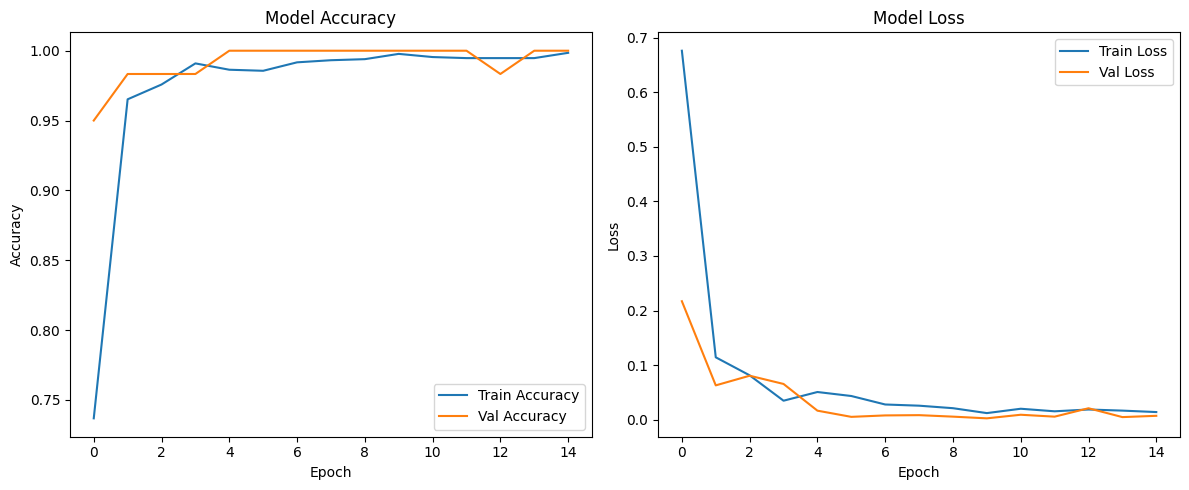

In [ ]:
import matplotlib.pyplot as plt

history_dict = history_res.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_probs_Res= model_RES.predict(x_train_origin)
y_pred_Res = np.argmax(y_pred_probs_Res, axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step


In [ ]:
datagen_Res_test = DataGenerator(model='ResNet50')
test_generator_Res = datagen_Res_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs_Res = model_RES.predict(test_generator_Res)
y_pred_Res = np.argmax(y_pred_probs_Res, axis=1)
y_true = y_test_encoded

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step


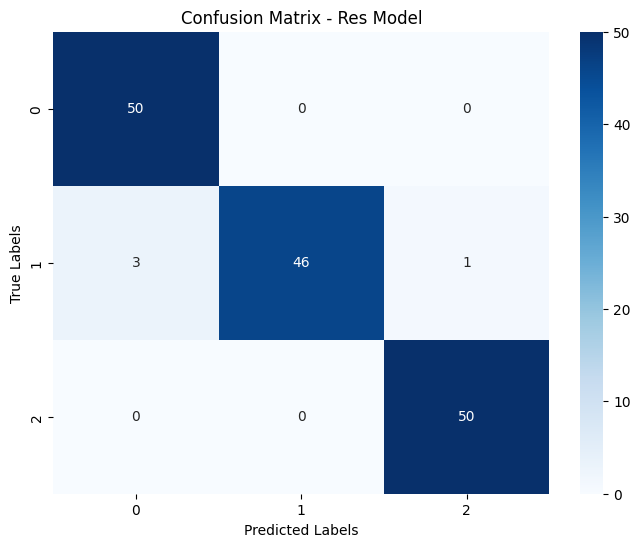

              precision    recall  f1-score   support

     class_0       0.96      0.98      0.97        50
     class_1       0.96      0.96      0.96        50
     class_2       1.00      0.98      0.99        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_Res)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Res Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

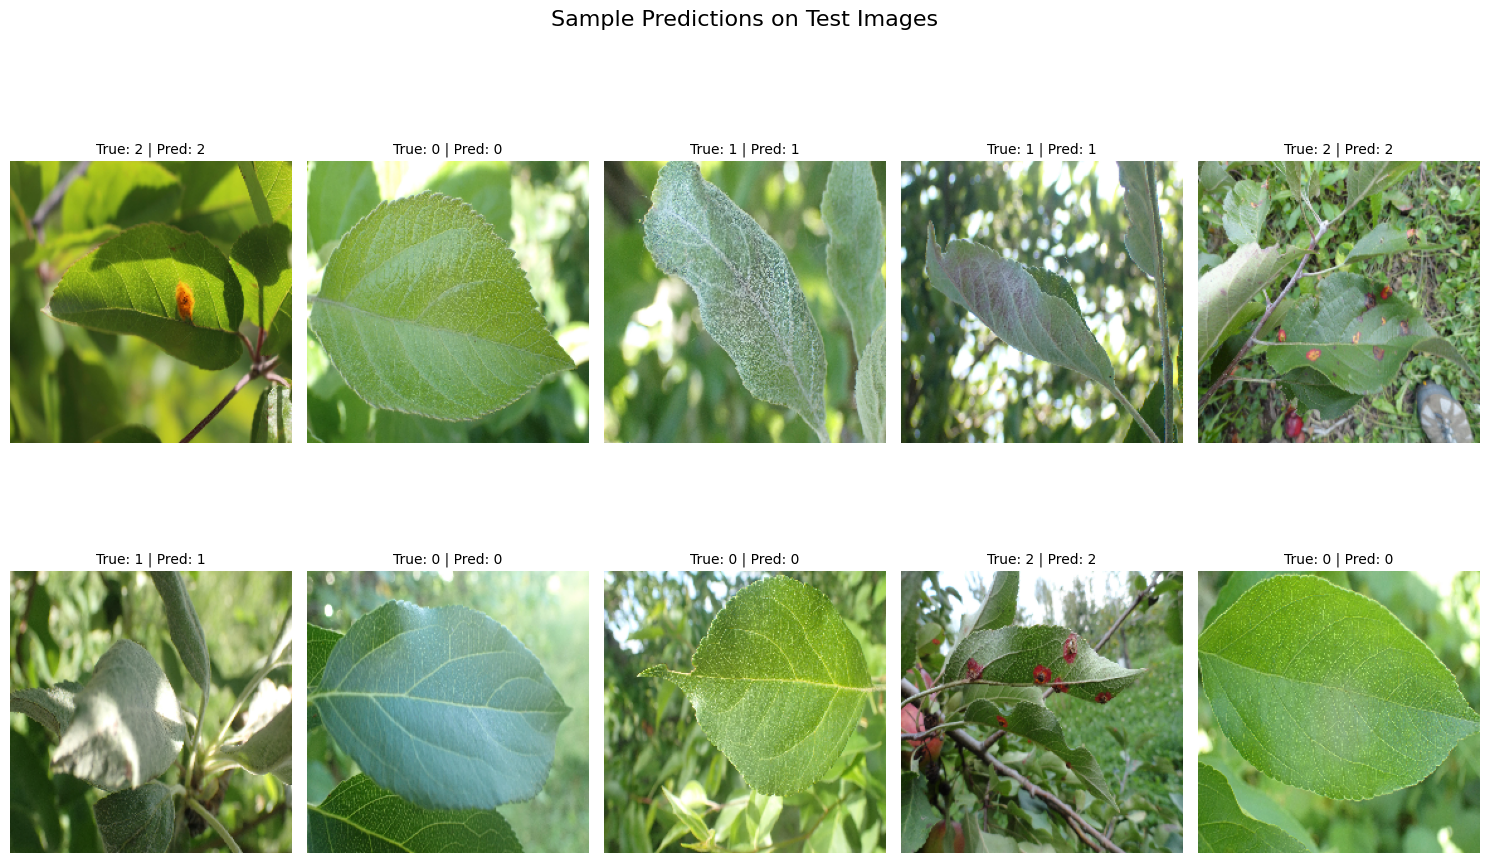

In [ ]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred_Res[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

# ResNet is the best! Yayyyy ❤